# Keyterm Parsing

In [1]:
import itertools
import networkx as nx
import nltk
import os
import numpy as np
import json

import matplotlib.pyplot as plt
import inflection
import string
import time

In [2]:
import spacy
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [3]:
with open('../samples/sample7.txt', 'r', encoding='utf-8') as f:
    text = f.read().replace('\n', ' ')

In [4]:
with open('../lib/plural_to_singular.json', 'r') as f:
    plural_to_singular = json.load(f)

In [5]:
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
# from textrank_spacy import extract_top_terms

In [8]:
# patterns = extract_top_terms(text, stopwords, plural_to_singular)

In [9]:
# patterns

In [10]:
# for pat in patterns:
#     if pat['id'] == 'neural-network':
#         print(pat)

## Entity Rules

Acroynms are defined as uppercase words of length greater than 1.

In [11]:
matcher = Matcher(nlp.vocab)
# Add match ID "HelloWorld" with no callback and one pattern
pattern = [{"IS_UPPER": True}]
matcher.add("acronym", None, pattern)

doc = nlp(text)
matches = matcher(doc)
acroynm_candidates = []
acroynm_set = set([])
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    if len(span.text) > 1 and span.text not in acroynm_set:
        acroynm_candidates.append(span)
        acroynm_set.add(span.text)
#     print(match_id, string_id, start, end, span.text)

In [12]:
acroynm_candidates

[E., R., OTHER, MERRIAM, WEBSTER, DICTIONARIES, FOLLOW, US]

In [30]:
def get_ent_id(span):
    simplified_tokens = []
    for token in span:
        text = token.text.lower()

        if token.is_upper:
            simplified_tokens.append(text)
        elif text not in stopwords and text not in string.punctuation:
            if text in plural_to_singular.keys():
                singular = plural_to_singular[text]
            else:
                singular = text
            simplified_tokens.append(singular)

    return '-'.join(simplified_tokens)

In [33]:
entity_rules = []
entity_set = set([])
entity_ids = set([])
skiplabels = [ 'DATE','TIME', 'PERCENT', 'MONEY', 'QUANTITY','ORDINAL', 'CARDINAL']
        
for ent in doc.ents:
    ent_id = get_ent_id(ent)
    # Ent id can't be empty string
    if ent_id == '':
        continue

    # Remove literal duplicates
    if ent.label_ not in skiplabels and ent.text not in entity_set:
        entity_rules.append((ent, ent_id))
        entity_set.add(ent.text)
        entity_ids.add(ent_id)

In [34]:
entity_rules

[(Verb, 'verb'),
 (New Yorker, 'new-yorker'),
 (Lily Tomlin, 'lily-tomlin'),
 (E. R. Black, 'e.-r.-black'),
 (Views, 'view'),
 (Merriam-Webster, 'merriam-webster'),
 (Middle English, 'middle-english'),
 (Anglo-French, 'anglo-french'),
 (Latin, 'latin'),
 (Num   , 'num-  '),
 (Number Ten   Social Security, 'number-ten-  -social-security'),
 (Cite this Entry, 'cite-entry'),
 (Number, 'number'),
 (Merriam, 'merriam'),
 (English, 'english'),
 (Spanish, 'spanish'),
 (Nglish:  Translation, 'nglish- -translation'),
 (Arabic, 'arabic'),
 (Britannica.com, 'britannica.com'),
 (Encyclopedia, 'encyclopedia'),
 (Comments, 'comment'),
 (Get Word of the, 'get-word'),
 (America, 'america'),
 (OTHER MERRIAM-WEBSTER DICTIONARIES, 'other-merriam-webster-dictionaries'),
 (FOLLOW, 'follow'),
 (US, 'us')]

In [21]:
ent_id_list = list(entity_ids)
acronym_pairs = {}
acronym_rules = []

for cand in acroynm_candidates:
    cand_lower = cand.text.lower()

    for ent_id in ent_id_list:
        tokens = ent_id.split('-')
        
        if len(cand_lower) == len(tokens):
            match = all([cand_lower[i] == tokens[i][0] for i in range(len(cand_lower))])
        else:
            match = False
        
        if match:
            acronym_pairs[cand_lower] = ent_id
            acronym_pairs[cand_lower + 's'] = ent_id
            
            acronym_rules.append((cand.text, ent_id))
            acronym_rules.append((cand.text + 's', ent_id))
            break

In [22]:
acronym_pairs

{}

In [23]:
acronym_rules

[]

In [24]:
entity_patterns = []

for chunk, ent_id in entity_rules:
    if chunk[0].text in ['the', 'The']:
        pattern = chunk[1:].text
    else:
        pattern = chunk.text
    
    if ent_id in acronym_pairs.keys():
        pattern_id = acronym_pairs[ent_id]
    else:
        pattern_id = ent_id
        
    entity_patterns.append({'label':'CUSTOM', 'pattern':pattern, 'id':pattern_id})

In [25]:
for pattern, ent_id in acronym_rules:
    entity_patterns.append({'label':'CUSTOM', 'pattern':pattern, 'id':ent_id})

In [26]:
entity_patterns

[{'label': 'CUSTOM', 'pattern': 'Verb', 'id': 'verb'},
 {'label': 'CUSTOM', 'pattern': 'New Yorker', 'id': 'new-yorker'},
 {'label': 'CUSTOM', 'pattern': 'Lily Tomlin', 'id': 'lily-tomlin'},
 {'label': 'CUSTOM', 'pattern': 'E. R. Black', 'id': 'e.-r.-black'},
 {'label': 'CUSTOM', 'pattern': 'Views', 'id': 'view'},
 {'label': 'CUSTOM', 'pattern': 'Merriam-Webster', 'id': 'merriam-webster'},
 {'label': 'CUSTOM', 'pattern': 'Middle English', 'id': 'middle-english'},
 {'label': 'CUSTOM', 'pattern': 'Anglo-French', 'id': 'anglo-french'},
 {'label': 'CUSTOM', 'pattern': 'Latin', 'id': 'latin'},
 {'label': 'CUSTOM', 'pattern': 'Num   ', 'id': 'num'},
 {'label': 'CUSTOM',
  'pattern': 'Number Ten   Social Security',
  'id': 'number-ten-social-security'},
 {'label': 'CUSTOM', 'pattern': 'Cite this Entry', 'id': 'cite-entry'},
 {'label': 'CUSTOM', 'pattern': 'Number', 'id': 'number'},
 {'label': 'CUSTOM', 'pattern': 'Merriam', 'id': 'merriam'},
 {'label': 'CUSTOM', 'pattern': 'English', 'id': 'e

## Find Keywords

Extract phrases using TextRank with no a priori assumptions on word relevance.

In [27]:
def get_word_list(sentence):
    word_list = []
    for w in sentence:
        if w.pos_ in ['ADJ', 'ADV', 'NOUN', 'PROPN', 'X'] and w.text not in word_list:
            word_list.append(w.text)
    return word_list

In [28]:
unique_word_set = set([])
edges = {}

for s in doc.sents:
    # tokenize the text using nltk
    word_list = get_word_list(s)
#     word_list.sort()

    for word in word_list:
        if word not in unique_word_set:
            unique_word_set.add(word)

    for pair in itertools.combinations(word_list, 2):
        if pair in edges.keys():
            edges[pair] += 1
        else:
            edges[pair] = 1

In [29]:
gr = nx.DiGraph()  # initialize an undirected graph
gr.add_nodes_from(unique_word_set)

for key, weight in edges.items():
    gr.add_edge(key[0], key[1], weight=weight)

In [30]:
len(gr.nodes)

176

In [31]:
calculated_page_rank = nx.pagerank(gr, weight='weight')

In [32]:
all_keywords = sorted(calculated_page_rank, key=calculated_page_rank.get,reverse=True)

In [33]:
def plot_bar(sorted_arr, scores, n=50):
    labels = []
    width = []
    for kp in sorted_arr[:n]:
        print(kp, scores[kp])
        labels.append(' '.join(kp) if isinstance(kp, tuple) or isinstance(kp, list) else kp)
        width.append(scores[kp])
        
    plt.figure(figsize=(5,10))
    plt.barh(range(len(labels), 0,-1), width=width, tick_label=labels)
    plt.show()

number 0.03928167654573092
Yorker 0.03898856975903574
Speakers 0.022427648012457963
agreement 0.021921155122107388
New 0.021076662558702157
free 0.019092507521732725
mass 0.017104377300102988
more 0.016872842311915368
Definition 0.01575994473522464
pebbles 0.014791618441791672
Share 0.014558188785809764
nuts 0.013278326035629714
word 0.012665282820941558
numbat 0.011850553170642295
black 0.011526447664189084
Dictionary 0.010363641777007772
ad 0.010320937114843467
numerus 0.009758686159652433
glad 0.009506616341842475
Webster 0.009306676969593414
amount 0.00929455100153153
time 0.008577962383465218
numb 0.008316707666409047
Nglish 0.008253763069862606
collection 0.0081254510927021
Learners 0.008067266695978624
vocab 0.008052401830622178
DICTIONARIES 0.008052401830622176
email 0.008052401830622176
money 0.007931282158362862
» 0.00792099203264243
usage 0.007823090501295248
Translation 0.007711744818598216
Latin 0.0076040377635674785
mainly 0.007449611908137487
English 0.0072878253946743
s

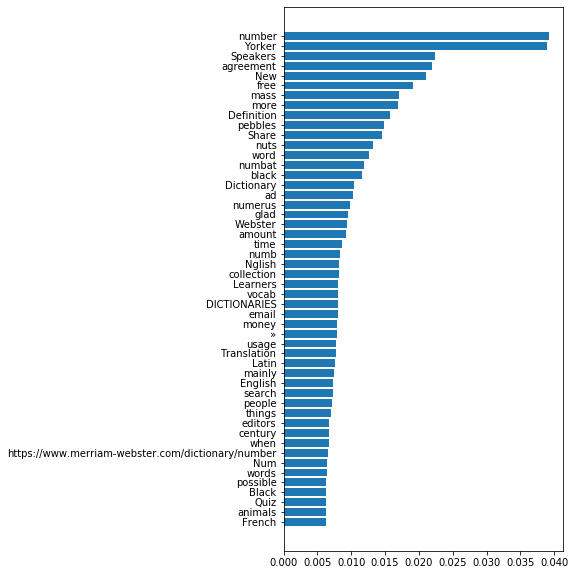

In [34]:
plot_bar(all_keywords, calculated_page_rank, n=50)

In [35]:
np.sum([calculated_page_rank[kp] for kp in all_keywords])

1.0000000000000004

## Find Phrases

In [36]:
textlist = [token.text for token in doc]
keywords = all_keywords[:len(all_keywords)//10]
phrase_freq = {}

In [37]:
def get_phrases(doc, keywords, k=2):
    # take keyphrases with multiple words into consideration as done in the
    # paper - if two words are adjacent in the text and are selected as
    # keywords, join them together
    modified_key_phrases = set([])
    # keeps track of individual keywords that have been joined to form a keyphrase
#     i = k-1
#     while i < len(textlist):
#         consecutive = tuple(textlist[i-k+1:i+1])
#         if all([word in keywords for word in consecutive]):
#             modified_key_phrases.add(consecutive)
#             if consecutive in phrase_freq.keys():
#                 phrase_freq[consecutive] += 1
#             else:
#                 phrase_freq[consecutive] = 1
#         i += 1

    i = k-1
    while i < len(doc):
        consecutive = tuple([token.text for token in doc[i-k+1:i+1]])
        if all([word in keywords for word in consecutive]):
            modified_key_phrases.add(consecutive)
            if consecutive in phrase_freq.keys():
                phrase_freq[consecutive] += 1
            else:
                phrase_freq[consecutive] = 1
        i += 1
        
    keyword_freq = {}
    for token in doc:
        if token.text in keywords:
            if token.text in keyword_freq.keys():
                keyword_freq[token.text] += 1
            else:
                keyword_freq[token.text] = 1
                
    return list(modified_key_phrases), keyword_freq

In [38]:
keyphrases, freq = get_phrases(doc, keywords, k=2)

In [39]:
keyphrases[:20]

[('number', 'agreement'),
 ('ad', 'free'),
 ('number', 'Definition'),
 ('New', 'Yorker'),
 ('black', 'pebbles'),
 ('Dictionary', 'number')]

In [40]:
phrase_scores = {}
for p in keyphrases:
#     print(p)
    phrase_scores[p] = np.power(np.prod([phrase_freq[p] / freq[w] for w in p]), 1/len(p))

In [41]:
sorted_phrases = sorted(phrase_scores, key=phrase_scores.get, reverse=True)

('ad', 'free') 1.0
('New', 'Yorker') 1.0
('black', 'pebbles') 1.0
('number', 'agreement') 0.1690308509457033
('number', 'Definition') 0.09759000729485331
('Dictionary', 'number') 0.09759000729485331


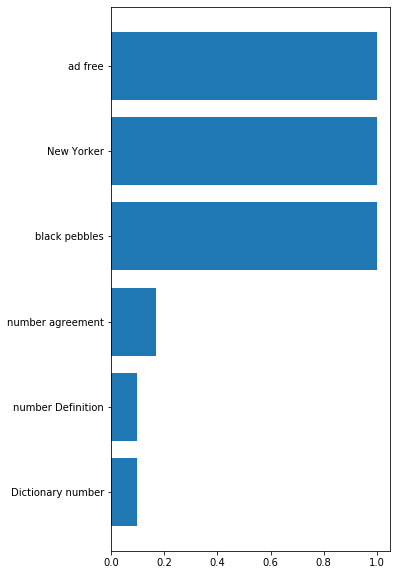

In [42]:
plot_bar(sorted_phrases, phrase_scores, n=40)

In [43]:
def get_top_half(sorted_list, scores):
    score_sum = sum([scores[k] for k in sorted_list])
    results = []
    s = 0
    i = 0
    while s < 0.5:
        norm_score = scores[sorted_list[i]] / score_sum
        s += norm_score
        results.append(sorted_list[i])
        i += 1
    return results

In [44]:
top_phrases = get_top_half(sorted_phrases, phrase_scores)

In [45]:
top_phrases

[('ad', 'free'), ('New', 'Yorker')]

### Add Phrases to Entity Rules

In [46]:
for phrase in top_phrases:
    pattern = ' '.join(phrase)
    pattern_id = get_ent_id(pattern)
    entity_patterns.append({'label':'CUSTOM', 'pattern': pattern, 'id':pattern_id})

In [47]:
entity_patterns

[{'label': 'CUSTOM', 'pattern': 'Verb', 'id': 'verb'},
 {'label': 'CUSTOM', 'pattern': 'New Yorker', 'id': 'new-yorker'},
 {'label': 'CUSTOM', 'pattern': 'Lily Tomlin', 'id': 'lily-tomlin'},
 {'label': 'CUSTOM', 'pattern': 'E. R. Black', 'id': 'e.-r.-black'},
 {'label': 'CUSTOM', 'pattern': 'Views', 'id': 'view'},
 {'label': 'CUSTOM', 'pattern': 'Merriam-Webster', 'id': 'merriam-webster'},
 {'label': 'CUSTOM', 'pattern': 'Middle English', 'id': 'middle-english'},
 {'label': 'CUSTOM', 'pattern': 'Anglo-French', 'id': 'anglo-french'},
 {'label': 'CUSTOM', 'pattern': 'Latin', 'id': 'latin'},
 {'label': 'CUSTOM', 'pattern': 'Num   ', 'id': 'num'},
 {'label': 'CUSTOM',
  'pattern': 'Number Ten   Social Security',
  'id': 'number-ten-social-security'},
 {'label': 'CUSTOM', 'pattern': 'Cite this Entry', 'id': 'cite-entry'},
 {'label': 'CUSTOM', 'pattern': 'Number', 'id': 'number'},
 {'label': 'CUSTOM', 'pattern': 'Merriam', 'id': 'merriam'},
 {'label': 'CUSTOM', 'pattern': 'English', 'id': 'e

In [52]:
def capitalize_word(text):
    return text[0:1].upper() + text[1:]

def get_variants(ent_id):
    """
    Given an entity id get capitalized and plural variants
    """

    tokens = ent_id.split('-')
    capitalized_tokens = [capitalize_word(word) for word in tokens]

    variants = set([])
    variants.add(' '.join(tokens))
    variants.add(' '.join(capitalized_tokens))
    variants.add(' '.join(tokens[:-1] + [inflection.pluralize(tokens[-1]),]))
    variants.add(' '.join(capitalized_tokens[:-1] + [inflection.pluralize(capitalized_tokens[-1]),]))
    return list(variants)

In [53]:
def _deduplicated_variants(patterns):
    all_patterns = []
    pattern_set = set([])
    ent_id_set = set([])

    for pat in patterns:
        if pat['pattern'] not in pattern_set:
            all_patterns.append(pat)
        pattern_set.add(pat['pattern'])

        if pat['id'] not in ent_id_set:
            for variant in get_variants(pat['id']):
                if variant not in pattern_set:
                    all_patterns.append({'label':'CUSTOM', 'pattern':variant, 'id':pat['id']})
                pattern_set.add(variant)
        ent_id_set.add(pat['id'])

    return all_patterns

In [54]:
patterns = _deduplicated_variants(entity_patterns)

In [55]:
patterns

[{'label': 'CUSTOM', 'pattern': 'Verb', 'id': 'verb'},
 {'label': 'CUSTOM', 'pattern': 'verbs', 'id': 'verb'},
 {'label': 'CUSTOM', 'pattern': 'verb', 'id': 'verb'},
 {'label': 'CUSTOM', 'pattern': 'Verbs', 'id': 'verb'},
 {'label': 'CUSTOM', 'pattern': 'New Yorker', 'id': 'new-yorker'},
 {'label': 'CUSTOM', 'pattern': 'New Yorkers', 'id': 'new-yorker'},
 {'label': 'CUSTOM', 'pattern': 'new yorker', 'id': 'new-yorker'},
 {'label': 'CUSTOM', 'pattern': 'new yorkers', 'id': 'new-yorker'},
 {'label': 'CUSTOM', 'pattern': 'Lily Tomlin', 'id': 'lily-tomlin'},
 {'label': 'CUSTOM', 'pattern': 'lily tomlins', 'id': 'lily-tomlin'},
 {'label': 'CUSTOM', 'pattern': 'Lily Tomlins', 'id': 'lily-tomlin'},
 {'label': 'CUSTOM', 'pattern': 'lily tomlin', 'id': 'lily-tomlin'},
 {'label': 'CUSTOM', 'pattern': 'E. R. Black', 'id': 'e.-r.-black'},
 {'label': 'CUSTOM', 'pattern': 'e. r. blacks', 'id': 'e.-r.-black'},
 {'label': 'CUSTOM', 'pattern': 'E. R. Blacks', 'id': 'e.-r.-black'},
 {'label': 'CUSTOM', 

## Dependency TextRank

In [49]:
ruler = EntityRuler(nlp)
# ruler.add_patterns(entity_patterns)

other_pipes = [p for p in nlp.pipe_names if p != "tagger"]
with nlp.disable_pipes(*other_pipes):
    ruler.add_patterns(entity_patterns)

nlp.add_pipe(ruler, before='ner')
modified_doc = nlp(text)

In [50]:
# for ent in modified_doc.ents:
#     if ent.label_ not in skiplabels:
#         print(ent.text, ent.label_, ent.ent_id_)

In [51]:
with modified_doc.retokenize() as retokenizer:
    for ent in modified_doc.ents:
        retokenizer.merge(ent)

In [52]:
# displacy.render(modified_doc, style="ent")

In [53]:
# displacy.render(modified_doc[:200], style="dep")

In [54]:
unique_word_set = set([])
edges = {}

for s in modified_doc.sents:
#     unique_nouns = set([])
    noun_list = []
    for token in s:
        if token.pos_ in ['NOUN', 'PROPN', 'X']:
            if token.ent_id_ != '':
                noun = token.ent_id_
            else:
                noun = token.lemma_
#             print(token.lemma_)
            if noun not in noun_list:
                noun_list.append(noun)
    print(noun_list)
    
    unique_word_set.update(noun_list)

    for pair in itertools.combinations(noun_list, 2):
        if pair in edges.keys():
            edges[pair] += 1
        else:
            edges[pair] = 1

['word']
['entry', 'number', 'game']
['number']
['definition', 'number']
['entry', 'verb']
['verb']
[]
['verb', 'synonyms']
['noun', 'synonyms']
['verb', 'noun']
['number', 'count', 'noun']
['number', 'mistake']
['number', 'time', 'amount', 'mass', 'noun']
['amount', 'rainfall', 'money']
['use', 'amount', 'count', 'noun', 'number', 'thing', 'mass', 'collection', 'black-pebble', 'new-yorker']
['amount', 'film']
['lily-tomlin', 'money']
['amount', 'loan', 'e.-r.-black']
['example', 'sentence', 'news', 'source', 'usage', 'word', 'number']
['view', 'example', 'opinion', 'merriam-webster', 'editor']
[]
['noun']
['14th century', 'meaning', 'sense']
['verb']
['14th century', 'meaning', 'sense']
['noun', 'verb']
['middle-english', 'nombre', 'anglo-french', 'latin', 'numerus']
['Share', 'number', 'Time', 'Traveler']
['word', 'the same century']
['num']
['numbat', 'number', 'agreement']
['number', 'board', 'cruncher']
['number-ten-social-security', 'number']
['number']
['number']
['number', 'pop

In [54]:
gr = nx.DiGraph()  # initialize an undirected graph
gr.add_nodes_from(unique_word_set)

for key, weight in edges.items():
    gr.add_edge(key[0], key[1], weight=weight)

In [55]:
len(gr.nodes)

113

In [56]:
calculated_page_rank = nx.pagerank(gr, weight='weight')

In [57]:
all_keywords = sorted(calculated_page_rank, key=calculated_page_rank.get,reverse=True)

number 0.07168820476392783
new-yorker 0.041203158569099674
Britannica.com 0.027915091003859804
antonyms 0.02347428832405252
black-pebble 0.02227200077715496
noun 0.020986562873996785
translation 0.01946197009354904
Speakers 0.018229058298987653
mass 0.017854875060233442
word 0.017554895501175127
numerus 0.016634229986085294
collection 0.01562964534047432
synonyms 0.01540997603786469
ad 0.015002155693398524
news 0.014951690377524354
Dictionary 0.014657435754043352
Traveler 0.013149232736181703
Learners 0.012777816226487033
time 0.012545201866018613
Definition 0.012287769502969313
money 0.011985855778025726
thing 0.011589035967219177
cruncher 0.011023635101331506
merriam-webster 0.010893172379482391
usage 0.010862776704464842
animal 0.010690073526907843
Quiz 0.010690073526907843
dictionary 0.010690073526907843
sense 0.010690073526907843
» 0.010690073526907843
english 0.01044581771725905
Central 0.009899719797392981
amount 0.009896215772665796
Language 0.00953579933377714
latin 0.00899139

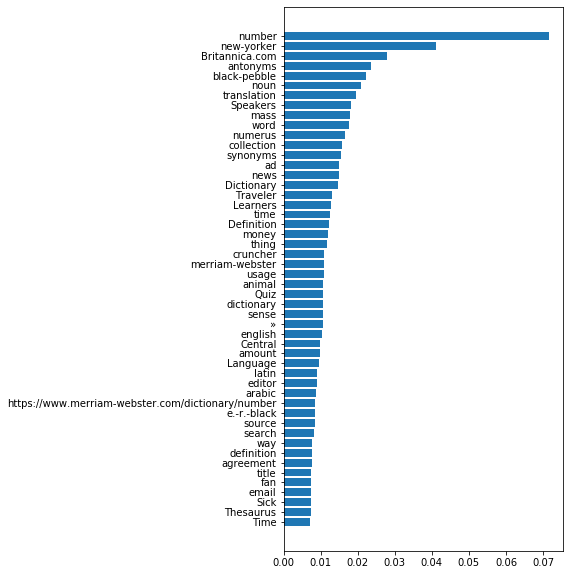

In [58]:
plot_bar(all_keywords, calculated_page_rank, n=50)